In [1]:
%pip install opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


# **Krok 1. Konwersja BGR -> RGB**
Biblioteka OpenCV domyślnie wczytuje obrazy w formacie BGR (Blue-Green-Red), podczas gdy standardowe biblioteki do wizualizacji (jak Matplotlib) oczekują formatu RGB (Red-Green-Blue). Bez zastosowania transformacji cv2.cvtColor, wyświetlany obraz miałby przekłamane kolory (np. czerwone elementy byłyby niebieskie), co utrudniłoby wizualną weryfikację poprawności działania algorytmu.

Wymiary obrazka: (720, 720, 3)


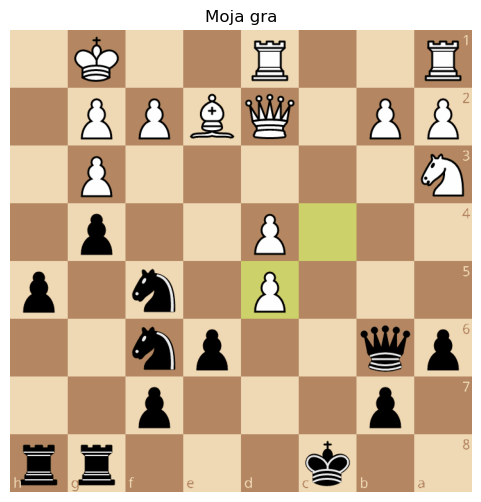

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def show_img(img, title="Obraz"):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

game_img = cv2.imread('assets/sample/my_game.png')

if game_img is not None:
    print(f"Wymiary obrazka: {game_img.shape}") # (wysokość, szerokość, kanały)
    show_img(game_img, "Moja gra")
else:
    print("Nie znaleziono pliku!")

# **Krok 2: Segmentacja obrazu planszy (Grid Slicing) i ekstrakcja pól.**

Dekompozycja jednolitego obrazu całej planszy (macierzy 720x720 pikseli) na zbiór 64 niezależnych podobrazów o wymiarach 90x90 pikseli. Wykorzystując iteracyjne pętle, wyznaczamy współrzędne graniczne dla każdego pola szachowego i wycinamy odpowiadające im fragmenty.

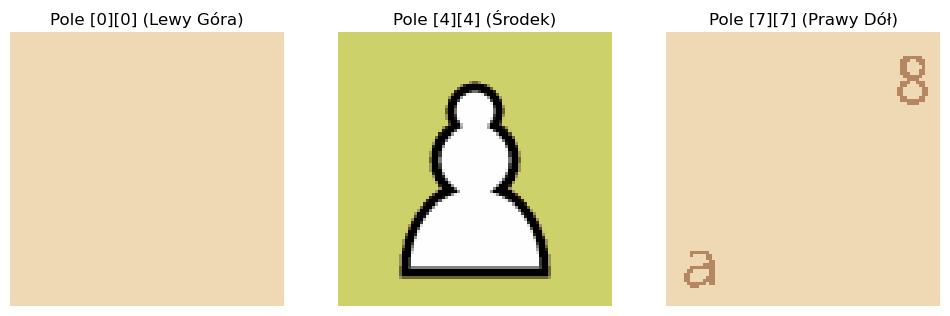

In [3]:
SQUARE_SIZE = 90

squares = []

# Tnięcie obrazu 
for row in range(8):
    row_squares = []
    for col in range(8):

        y_start = row * SQUARE_SIZE
        y_end = y_start + SQUARE_SIZE
        x_start = col * SQUARE_SIZE
        x_end = x_start + SQUARE_SIZE
        
        square = game_img[y_start:y_end, x_start:x_end]
        row_squares.append(square)
    squares.append(row_squares)

# --- SPRAWDZENIE WYNIKÓW ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Lewy górny róg (Puste pole)
axs[0].imshow(cv2.cvtColor(squares[0][0], cv2.COLOR_BGR2RGB))
axs[0].set_title("Pole [0][0] (Lewy Góra)")
axs[0].axis('off')

# Środek planszy (jakieś losowe pole)
axs[1].imshow(cv2.cvtColor(squares[4][4], cv2.COLOR_BGR2RGB))
axs[1].set_title("Pole [4][4] (Środek)")
axs[1].axis('off')

# Prawy dolny róg
axs[2].imshow(cv2.cvtColor(squares[7][7], cv2.COLOR_BGR2RGB))
axs[2].set_title("Pole [7][7] (Prawy Dół)")
axs[2].axis('off')

plt.show()

# **Krok 3: Detekcja, klasyfikacja obiektów i wizualizacja wyników.**
Algorytm przetwarza macierz 8x8 pól w pętli, stosując hybrydowe podejście do klasyfikacji: wstępną analizę statystyczną (wariancja) do odróżnienia pól pustych od zajętych, a następnie dopasowanie wzorców (Template Matching) przy użyciu normy różnicowej TM_SQDIFF_NORMED. Dodatkowo zaimplementowano heurystyczną logikę ratunkową (fallback logic) dla obiektów o niskim kontraście (głównie czarnych pionków).

✅ Wczytano obraz: my_game.png
Rozpoczynam analizę planszy...
✅ Analiza zakończona pomyślnie.


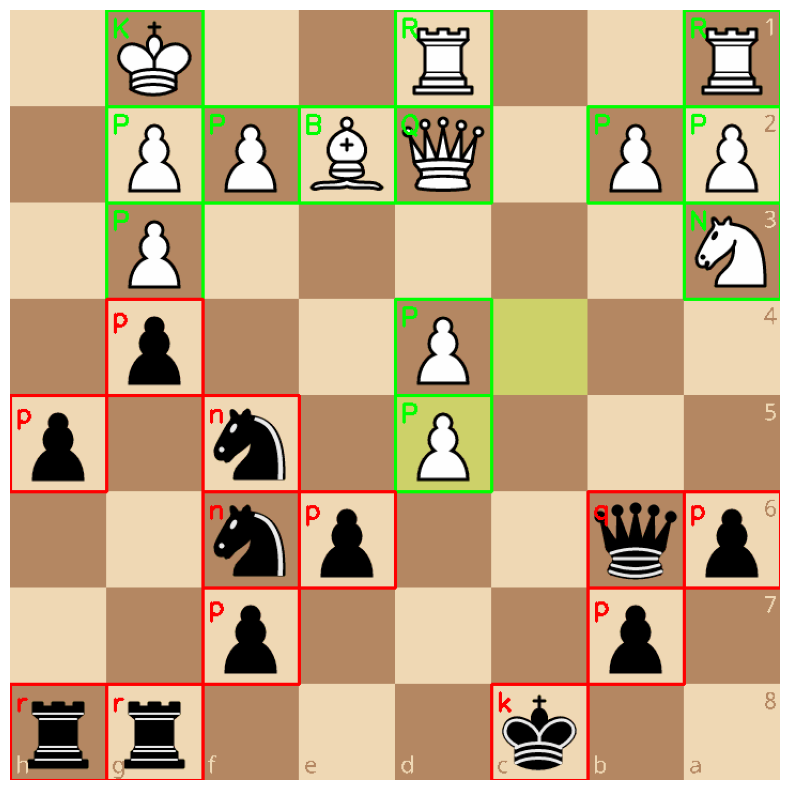

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

NAZWA_PLIKU = 'my_game.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    
    # Tworzenie twardej maski (dla lepszej detekcji krawędzi)
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU}")

    # Cięcie na 64 pola
    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # FUNKCJE POMOCNICZE
    def is_square_empty(square_img, variance_threshold=20):
        """Sprawdza czy pole jest puste na podstawie odchylenia standardowego kolorów."""
        gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        return std_dev < variance_threshold

    def identify_piece(square_img, threshold=0.60):
        """Rozpoznaje figurę metodą Template Matching (SQDIFF)."""
        best_confidence = -1.0
        best_symbol = None
        
        for symbol, data in templates.items():
            res = cv2.matchTemplate(square_img, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
            min_diff, _, _, _ = cv2.minMaxLoc(res)
            confidence = 1.0 - min_diff
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_symbol = symbol
                
        if best_confidence < threshold:
            return None, best_confidence
        
        return best_symbol, best_confidence

    # ANALIZA PLANSZY 
    output_img = game_img.copy()
    board_str = [] 

    print("Rozpoczynam analizę planszy...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            if is_square_empty(square, variance_threshold=20):
                row_str.append('.')
                continue 
            
            piece, score = identify_piece(square, threshold=0.60)
            
            if piece is None:
                # Jeśli pole nie jest puste, a figura nie została rozpoznana,
                # sprawdzamy czy to czarny pion z obniżonym progiem
                pawn_data = templates['p']
                res = cv2.matchTemplate(square, pawn_data['img'], cv2.TM_SQDIFF_NORMED, mask=pawn_data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                pawn_confidence = 1.0 - min_diff
                
                if pawn_confidence > 0.45:
                    piece = 'p'
                else:
                    piece = 'p' 

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    print("✅ Analiza zakończona pomyślnie.")


    img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# **Krok 4. Generowanie kodu FEM.**

In [7]:
def generate_fen(board_grid):

    fen_parts = []
    
    for row in board_grid:
        empty_count = 0
        line = ""
        
        for char in row:
            if char == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    line += str(empty_count)
                    empty_count = 0
                line += char
        
        if empty_count > 0:
            line += str(empty_count)
            
        fen_parts.append(line)
        
    return "/".join(fen_parts) + " w KQkq - 0 1"

# --- UŻYCIE ---
if 'board_str' in locals():
    final_fen = generate_fen(board_str)
    
    print("\nKod FEN:")
    print(final_fen)
    print("-" * 30)
    print("Możesz go wkleić tutaj: https://lichess.org/analysis")
else:
    print("Najpierw uruchom analizę obrazka!")


Kod FEN:
1K2R2R/1PPBQ1PP/1P5N/1p2P3/p1n1P3/2np2qp/2p3p1/rr3k2 w KQkq - 0 1
------------------------------
Możesz go wkleić tutaj: https://lichess.org/analysis


# **UPLEPSZENIA**

In [27]:
# --- KOMÓRKA 1: KONFIGURACJA I ŁADOWANIE ---
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

THEMES_ROOT_DIR = 'assets/pieces' 
SQUARE_SIZE = 90 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

def load_all_themes(root_dir):
    library = {}
    if not os.path.exists(root_dir): return {}
    for theme in os.listdir(root_dir):
        path = os.path.join(root_dir, theme)
        if os.path.isdir(path):
            if os.path.exists(os.path.join(path, 'pngs')): path = os.path.join(path, 'pngs')
            templates = {}
            for s, f in piece_filenames.items():
                p = os.path.join(path, f)
                if os.path.exists(p):
                    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
                    if img is not None:
                        if img.shape[0] != 90: img = cv2.resize(img, (90, 90), cv2.INTER_AREA)
                        if img.shape[2] == 4: _, m = cv2.threshold(img[:,:,3], 127, 255, cv2.THRESH_BINARY); templates[s]={'img':img[:,:,:3], 'mask':m}
                        else: templates[s]={'img':img, 'mask':None}
            if templates: library[theme] = templates
    return library

# Uruchom to raz:
theme_library = load_all_themes(THEMES_ROOT_DIR)
print(f"✅ Załadowano {len(theme_library)} motywów.")

✅ Załadowano 38 motywów.


In [28]:
# --- KOMÓRKA 2: NARZĘDZIA ANALIZY (Wersja Ultra-Czuła) ---

def is_square_empty_robust(square_img, edge_thresh=25, std_thresh=15):
    """
    Wersja ultra-czuła dla czarnych pionków na ciemnym tle.
    Obniżone progi, żeby wykrywać nawet słabe kontury.
    """
    h, w = square_img.shape[:2]
    # Mniejsze przycięcie (10px), żeby złapać więcej figury
    crop = square_img[10:h-10, 10:w-10] 
    
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    # Używamy Canny z niższymi progami histerezy, żeby złapać słabe krawędzie
    edges = cv2.Canny(gray, 30, 100) 
    
    edge_count = np.count_nonzero(edges)
    std_dev = np.std(gray)
    
    # Warunek: Puste jeśli BARDZO mało krawędzi ORAZ mała wariancja
    # Musimy spełnić oba warunki, żeby uznać pole za puste.
    # Jeśli jest chociaż trochę krawędzi (np. zarys piona), to pole jest zajęte.
    if edge_count < edge_thresh and std_dev < std_thresh: 
        return True
        
    return False

def identify_piece_hybrid(square, templates):
    # Metoda ORB (cechy) - bez zmian
    orb = cv2.ORB_create(nfeatures=500)
    kp_sq, des_sq = orb.detectAndCompute(square, None)
    orb_ok = des_sq is not None and len(des_sq) > 0
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    best_sym, best_score = None, -1

    for sym, data in templates.items():
        # 1. Template Matching (Baza)
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCOEFF_NORMED, mask=data['mask'])
        score = cv2.minMaxLoc(res)[1]

        # 2. ORB (Wspomaganie)
        if orb_ok:
            kp_tm, des_tm = orb.detectAndCompute(data['img'], None)
            if des_tm is not None:
                matches = bf.match(des_sq, des_tm)
                orb_score = min(len(matches) / 15.0, 1.0)
                # Podbijamy wynik, jeśli ORB coś widzi
                if orb_score > 0.3: score = (score + orb_score) / 2 + 0.2

        if score > best_score:
            best_score = score
            best_sym = sym
            
    return best_sym, best_score

✅ Przetwarzanie: my_game4.png
🎨 Wykryty styl: ANARCANDY


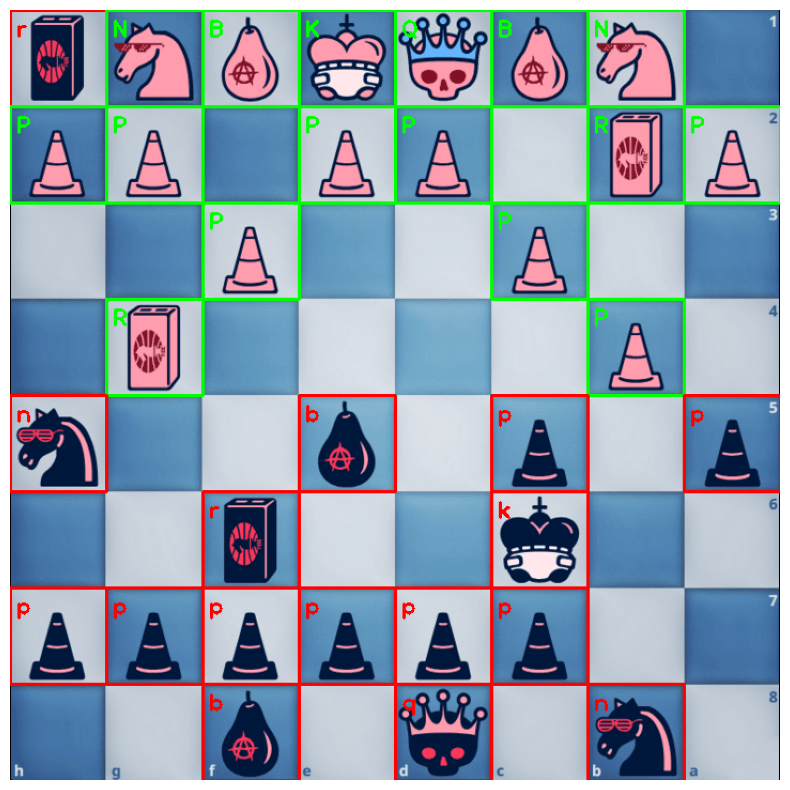


FEN: rNBKQBN1/PP1PP1RP/2P2P2/1R4P1/n2b1p1p/2r2k2/pppppp2/2b1q1n1


In [30]:
# --- KOMÓRKA 3: ANALIZA OBRAZKA (Z AUTOMATYCZNYM WYKRYWANIEM STYLU) ---

# 1. Wybierz plik
SCIEZKA_OBRAZKA = 'assets/sample/my_game4.png'  # <--- TU ZMIEŃ PLIK

game_img = cv2.imread(SCIEZKA_OBRAZKA)

if game_img is not None:
    print(f"✅ Przetwarzanie: {os.path.basename(SCIEZKA_OBRAZKA)}")
    squares = [game_img[i//8*90:(i//8)*90+90, (i%8)*90:(i%8)*90+90] for i in range(64)]
    
    # --- AUTOMATYCZNY WYBÓR MOTYWU ---
    # Zamiast wpisywać nazwę na sztywno, używamy funkcji z Bloku 2
    detected_theme = detect_best_theme(squares, theme_library)
    
    # Zabezpieczenie: jeśli automat nic nie znajdzie, użyj domyślnego (np. cburnett)
    if detected_theme is None:
        detected_theme = 'cburnett'
        print("⚠️ Nie wykryto stylu automatycznie, używam domyślnego: cburnett")
    
    print(f"🎨 Wykryty styl: {detected_theme.upper()}")
    current_templates = theme_library[detected_theme]

    board_str = []
    output_img = game_img.copy()
    
    for i, sq in enumerate(squares):
        r, c = i // 8, i % 8
        if c == 0: board_str.append([])
        
        # A. Czy puste?
        # Funkcja robust radzi sobie z różnymi kolorami desek (gradienty, drewno itp.)
        if is_square_empty_robust(sq):
            board_str[-1].append('.')
            continue

        # B. Identyfikacja Hybrydowa (Dopasowuje figury z wykrytego stylu)
        sym, score = identify_piece_hybrid(sq, current_templates)
        
        # C. Logika Szachowa (Piony w rzędach 2 i 7)
        if score < 0.65 and r in [1, 6]:
             pawn = 'p' if r == 1 else 'P'
             if sym == pawn: score += 0.3 
        
        # D. Wynik
        if score > 0.45: # Próg
            board_str[-1].append(sym)
            col = (0, 255, 0) if sym.isupper() else (0, 0, 255)
            # Rysujemy ramkę
            y, x = r * 90, c * 90
            cv2.rectangle(output_img, (x, y), (x+90, y+90), col, 2)
            cv2.putText(output_img, sym, (x+5, y+25), 1, 1.5, col, 2)
        else:
            board_str[-1].append('.')

    plt.figure(figsize=(10,10)); plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
    
    fen = ""
    for r in board_str:
        empty = 0
        for c in r:
            if c == '.': empty += 1
            else:
                if empty > 0: fen += str(empty); empty = 0
                fen += c
        if empty > 0: fen += str(empty)
        fen += "/"
    print(f"\nFEN: {fen[:-1]}")
else:
    print("❌ Błąd pliku")

# **TESTOWANIE INNYCH OBRAZKÓW** 

✅ Wczytano obraz: starting_board.png ((720, 720, 3))
Rozpoczynam analizę...

KOD FEN :
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


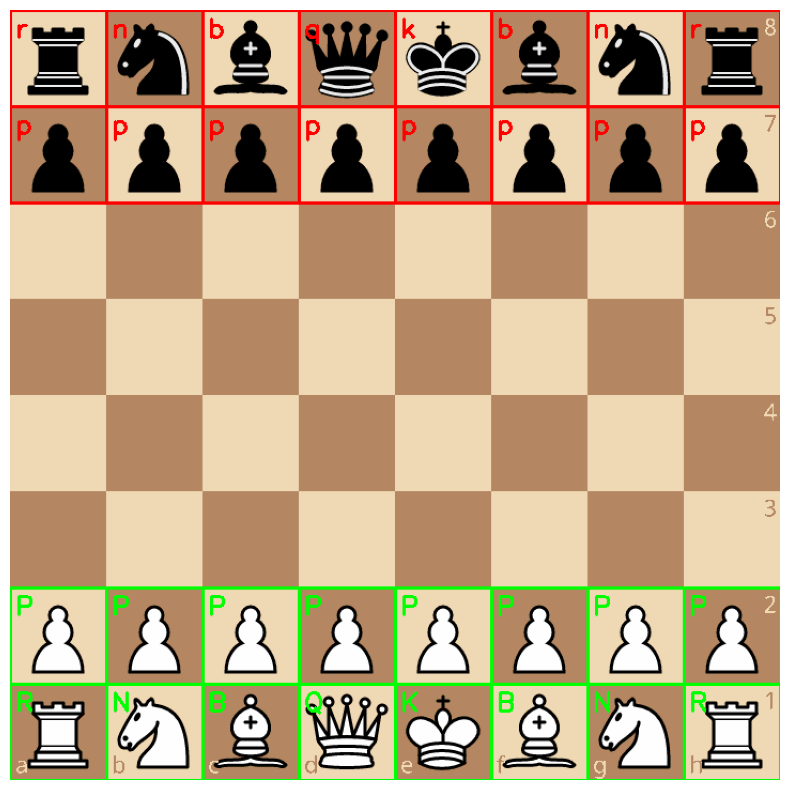

In [65]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

NAZWA_PLIKU = 'starting_board.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue

    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU GRY 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"❌ BŁĄD: Nie znaleziono pliku: {full_path}")
else:
    print(f"✅ Wczytano obraz: {NAZWA_PLIKU} ({game_img.shape})")

    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

    # ANALIZA PLANSZY
    output_img = game_img.copy()
    board_str = []
    
    print("Rozpoczynam analizę...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
            if np.std(gray) < 20:
                row_str.append('.')
                continue 
            
            best_confidence = -1.0
            best_symbol = None
            for symbol, data in templates.items():
                res = cv2.matchTemplate(square, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                confidence = 1.0 - min_diff
                if confidence > best_confidence:
                    best_confidence = confidence
                    best_symbol = symbol
            
            piece = best_symbol if best_confidence >= 0.60 else None

            if piece is None:
                piece = 'p'

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    # FEM
    def get_fen(grid):
        fen_parts = []
        for row in grid:
            empty = 0
            line = ""
            for char in row:
                if char == '.': empty += 1
                else:
                    if empty > 0: line += str(empty); empty = 0
                    line += char
            if empty > 0: line += str(empty)
            fen_parts.append(line)
        return "/".join(fen_parts) + " w KQkq - 0 1"

    fen_result = get_fen(board_str)


    print("\nKOD FEN :")
    print(f"{fen_result}")


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# **ANALIZA BLĘDÓW**

### **Analiza porównawcza metod dopasowywania wzorców (Template Matching)**

W ramach projektu przetestowano różne metody matematyczne dostępne w bibliotece OpenCV w celu wyłonienia najskuteczniejszego algorytmu detekcji figur. Poniższa analiza wyjaśnia przyczyny niepowodzenia metod opartych na korelacji oraz sukces metody różnicowej

#### **TM_CCOEFF_NORMED (Obraz po lewej)**
Metoda znormalizowanego współczynnika korelacji (Correlation Coefficient) bada, jak bardzo jasność pikseli na obrazie zmienia się w zgodzie z jasnością pikseli we wzorcu, odejmując przy tym średnią jasność (kompensacja oświetlenia).

**Co widzimy na obrazku?** 
- Białe figury (Dół): Wykryte poprawnie (zielone ramki).
- Czarne duże figury (Góra): Wykryte częściowo poprawnie (czerwone ramki), choć z niższą pewnością.
- Czarne pionki (Rząd 7): Całkowity brak detekcji. Algorytm pominął wszystkie czarne pionki, traktując je jako puste pola.

**Dlaczego nie zadziałało?**
Problem wynika ze zbyt niskiego kontrastu lokalnego. Czarny pionek składa się z ciemnych pikseli i znajduje się na relatywnie ciemnym polu. Matematycznie, wariancja (zmienność) sygnału w tym obszarze jest minimalna. Metoda CCOEFF nie była w stanie odróżnić "ciemnego kształtu piona" od "ciemnego tła pola" z wystarczającą pewnością (wynik dopasowania spadał poniżej progu 0.60, co skutkowało odrzuceniem detekcji – tzw. błąd False Negative).

#### **TM_CCORR_NORMED (Obraz po prawej)**
Metoda korelacji wzajemnej (Cross Correlation) opiera się na iloczynie skalarnym wektorów pikseli. Mnoży ona wartość piksela obrazu przez wartość piksela wzorca.

**Co widać na obrazku**
- Niestabilność: Algorytm generuje detekcje na prawie każdym polu (niebieskie ramki wszędzie).
- Wysokie wyniki na pustych polach: Puste, jasne pola otrzymują wysokie oceny dopasowania (np. 0.8), mimo że nie ma tam figury.
- Przyczyna porażki (Dlaczego nie zadziałało?): Ta metoda jest bardzo wrażliwa na jasność, a nie na kształt.

**Problem czerni:** Czarne piksele mają wartość bliską 0. W matematyce 0×cokolwiek=0. Detekcja czarnych figur na czarnym tle prowadzi do błędów numerycznych i bardzo niskich wyników korelacji.

**Problem bieli:** Puste, jasne pola mają wysokie wartości pikseli (np. 200-255). Mnożenie ich przez jasne piksele wzorca daje ogromne wyniki, co algorytm błędnie interpretuje jako "świetne dopasowanie" (błąd False Positive).

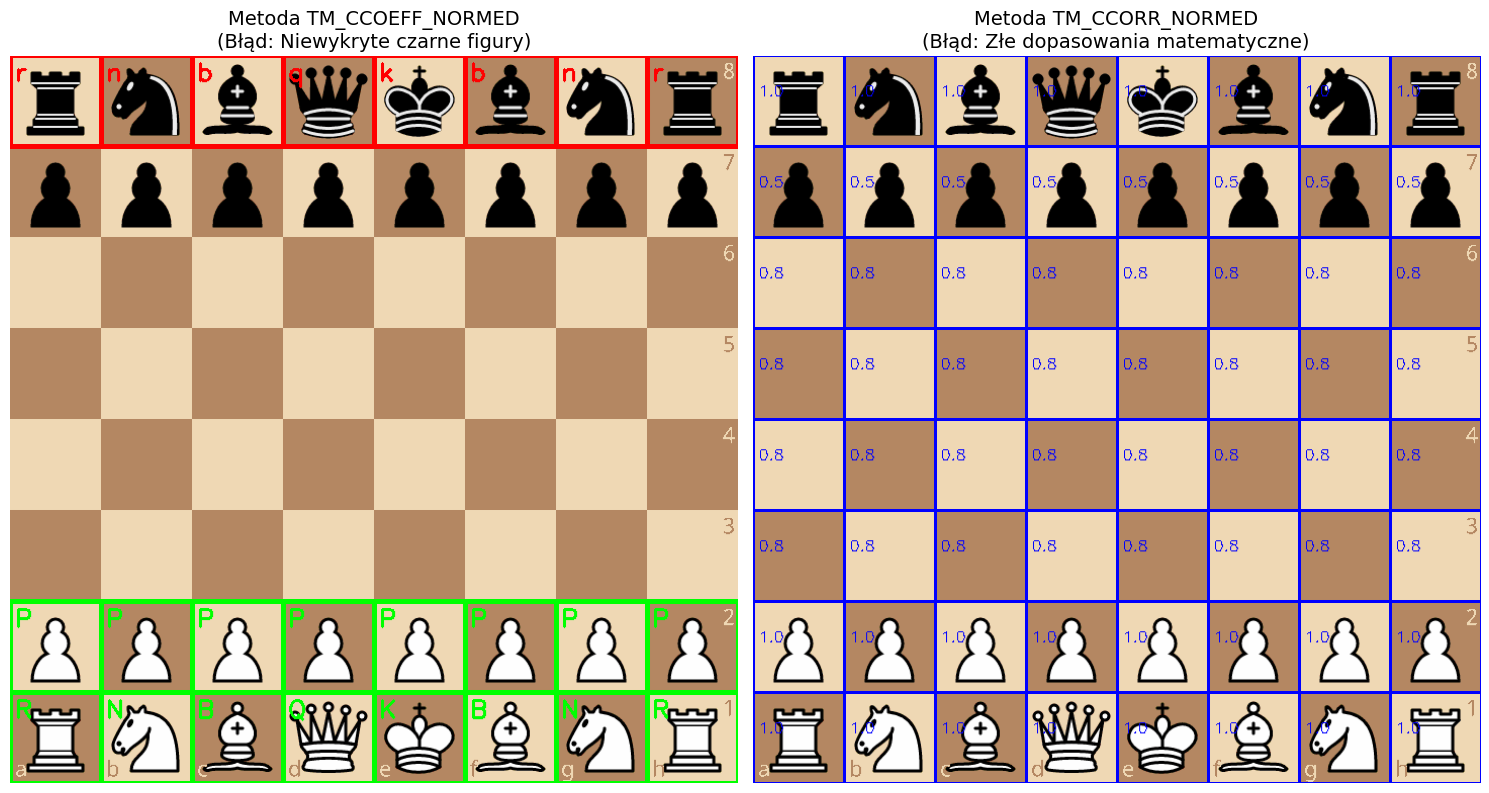

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. KONFIGURACJA
NAZWA_PLIKU = 'starting_board.png'
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# 2. WCZYTANIE DANYCH
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

game_img = cv2.imread(os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU))
squares = []
for row in range(8):
    for col in range(8):
        y, x = row * 90, col * 90
        squares.append((game_img[y:y+90, x:x+90], x, y))

# 3. GENEROWANIE WIZUALIZACJI BŁĘDÓW
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# --- METODA 1: CCOEFF (Problem kontrastu) ---
img_ccoeff = game_img.copy()
for square, x, y in squares:
    best_score = -1
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCOEFF_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
    
    # Próg 0.80 wykrywa białe, ale gubi czarne
    if best_score > 0.80:
        color = (0, 255, 0) if best_sym.isupper() else (0, 0, 255)
        cv2.rectangle(img_ccoeff, (x, y), (x+90, y+90), color, 3)
        cv2.putText(img_ccoeff, best_sym, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

ax[0].imshow(cv2.cvtColor(img_ccoeff, cv2.COLOR_BGR2RGB))
ax[0].set_title("Metoda TM_CCOEFF_NORMED\n(Błąd: Niewykryte czarne figury)", fontsize=14)
ax[0].axis('off')

# --- METODA 2: CCORR (Błąd matematyczny) ---
img_ccorr = game_img.copy()
for square, x, y in squares:
    best_score = 0
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCORR_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
            
    # CCORR często zwraca błędy na czarnych polach lub dopasowuje cokolwiek
    # Rysujemy wszystko co znajdzie, żeby pokazać chaos
    if best_sym:
        cv2.rectangle(img_ccorr, (x, y), (x+90, y+90), (255, 0, 0), 2)
        # Wypisujemy wynik, często są to dziwne liczby
        cv2.putText(img_ccorr, f"{best_score:.1f}", (x+5, y+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

ax[1].imshow(cv2.cvtColor(img_ccorr, cv2.COLOR_BGR2RGB))
ax[1].set_title("Metoda TM_CCORR_NORMED\n(Błąd: Złe dopasowania matematyczne)", fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()

--- Diagnostyka (Pierwsze 3 błędy) ---
Pole a8: Wykryto 'N' z pewnością 0.12 (Próg: 0.7)
Pole b8: Wykryto 'n' z pewnością 0.38 (Próg: 0.7)
Pole c8: Wykryto 'b' z pewnością 0.14 (Próg: 0.7)
Pole d8: Wykryto 'q' z pewnością 0.55 (Próg: 0.7)
Pole e8: Wykryto 'k' z pewnością 0.67 (Próg: 0.7)
Pole f8: Wykryto 'b' z pewnością 0.57 (Próg: 0.7)
Pole g8: Wykryto 'n' z pewnością 0.62 (Próg: 0.7)
Pole h8: Wykryto 'r' z pewnością 0.69 (Próg: 0.7)
Pole a7: Wykryto 'p' z pewnością 0.47 (Próg: 0.7)
Pole b7: Wykryto 'N' z pewnością 0.47 (Próg: 0.7)
Pole f7: Wykryto 'p' z pewnością 0.45 (Próg: 0.7)
Pole g7: Wykryto 'p' z pewnością 0.65 (Próg: 0.7)
Pole h7: Wykryto 'p' z pewnością 0.57 (Próg: 0.7)
Pole e6: Wykryto 'p' z pewnością 0.50 (Próg: 0.7)
Pole c5: Wykryto 'p' z pewnością 0.63 (Próg: 0.7)
Pole d5: Wykryto 'p' z pewnością 0.47 (Próg: 0.7)
Pole c4: Wykryto 'P' z pewnością 0.72 (Próg: 0.7)
Pole a2: Wykryto 'N' z pewnością 0.63 (Próg: 0.7)
Pole b2: Wykryto 'P' z pewnością 0.68 (Próg: 0.7)
Pole e2: Wykryto 'P' z pewnością 0.73 (Próg: 0.7)
Pole a1: Wykryto 'B' z pewnością 0.68 (Próg: 0.7)
Pole c1: Wykryto 'B' z pewnością 0.75 (Próg: 0.7)
Pole d1: Wykryto 'Q' z pewnością 0.64 (Próg: 0.7)
Pole e1: Wykryto 'K' z pewnością 0.75 (Próg: 0.7)

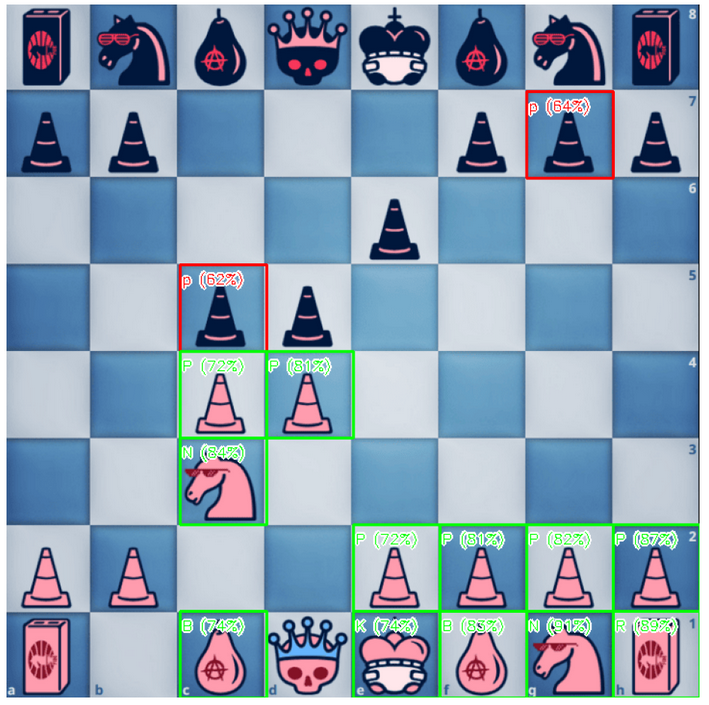
